1. Import Libraries

In [75]:
# CELL 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [78]:
# CELL 2: Load Data
df = pd.read_csv('..\data\students.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (500, 11)

First few rows:


,student_id,java,python,database,web_dev,networks,machine_learning,cybersecurity,mobile_dev,gpa,recommended_domain
0,STU0001,18.95,15.88,12.08,19.08,9.49,11.21,11.50,14.91,14.14,Software Engineering
1,STU0002,12.73,14.67,13.35,16.24,13.49,8.99,10.76,14.35,13.07,Web Development
2,STU0003,17.05,15.25,14.29,17.02,14.45,7.12,14.32,12.29,13.97,Software Engineering
3,STU0004,15.69,9.23,14.90,12.53,12.25,12.37,13.44,18.54,13.62,Mobile Development
4,STU0005,17.49,10.59,16.77,13.01,10.92,12.67,11.07,17.34,13.73,Mobile Development


In [79]:
#ceLL 3: Data Exploration - Basic Info
print("Dataset Information:")
print(df.info())
print("\n" + "="*50)
print("\nStatistical Summary:")
print(df.describe())
print("\n" + "="*50)
print("\nMissing Values:")
print(df.isnull().sum())
print("\n" + "="*50)
print(f"\nDuplicate rows: {df.duplicated().sum()}")
print("\n" + "="*50)
print("\nTarget Variable Distribution:")
print(df['recommended_domain'].value_counts())
print(f"\nNumber of unique domains: {df['recommended_domain'].nunique()}")

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   student_id          500 non-null    object 
 1   java                500 non-null    float64
 2   python              500 non-null    float64
 3   database            500 non-null    float64
 4   web_dev             500 non-null    float64
 5   networks            500 non-null    float64
 6   machine_learning    500 non-null    float64
 7   cybersecurity       500 non-null    float64
 8   mobile_dev          500 non-null    float64
 9   gpa                 500 non-null    float64
 10  recommended_domain  500 non-null    object 
dtypes: float64(9), object(2)
memory usage: 43.1+ KB
None


Statistical Summary:
             java      python    database     web_dev    networks  \
count  500.000000  500.000000  500.000000  500.000000  500.000000   
mean    14.278680 

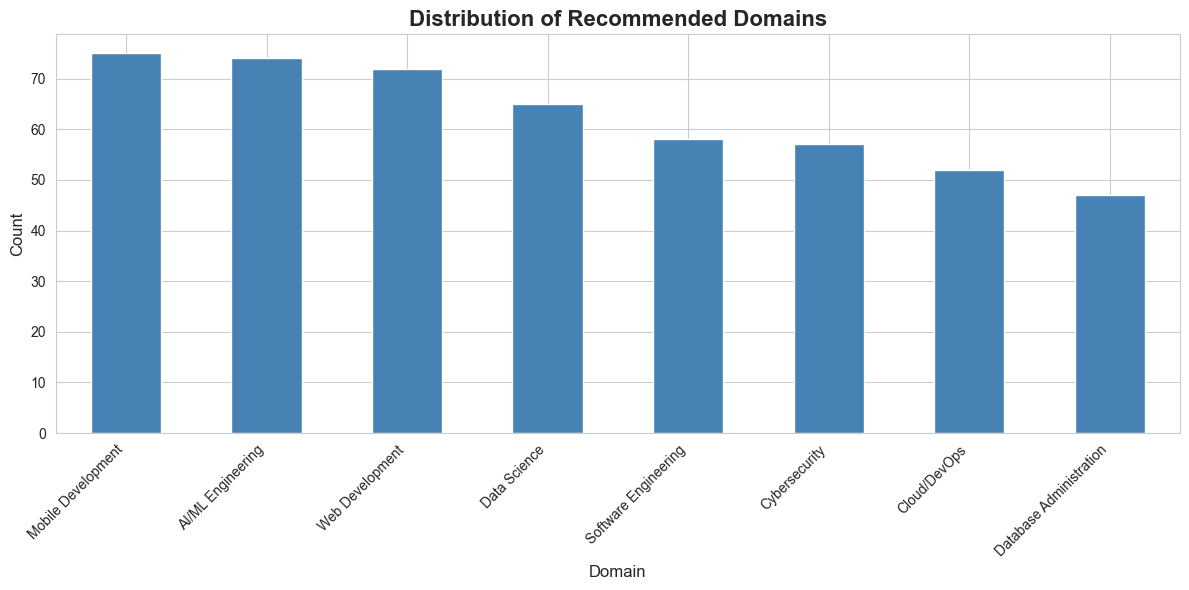

In [80]:
#LL 4: Visualize Target Distribution
plt.figure(figsize=(12, 6))
df['recommended_domain'].value_counts().plot(kind='bar', color='steelblue')
plt.title('Distribution of Recommended Domains', fontsize=16, fontweight='bold')
plt.xlabel('Domain', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

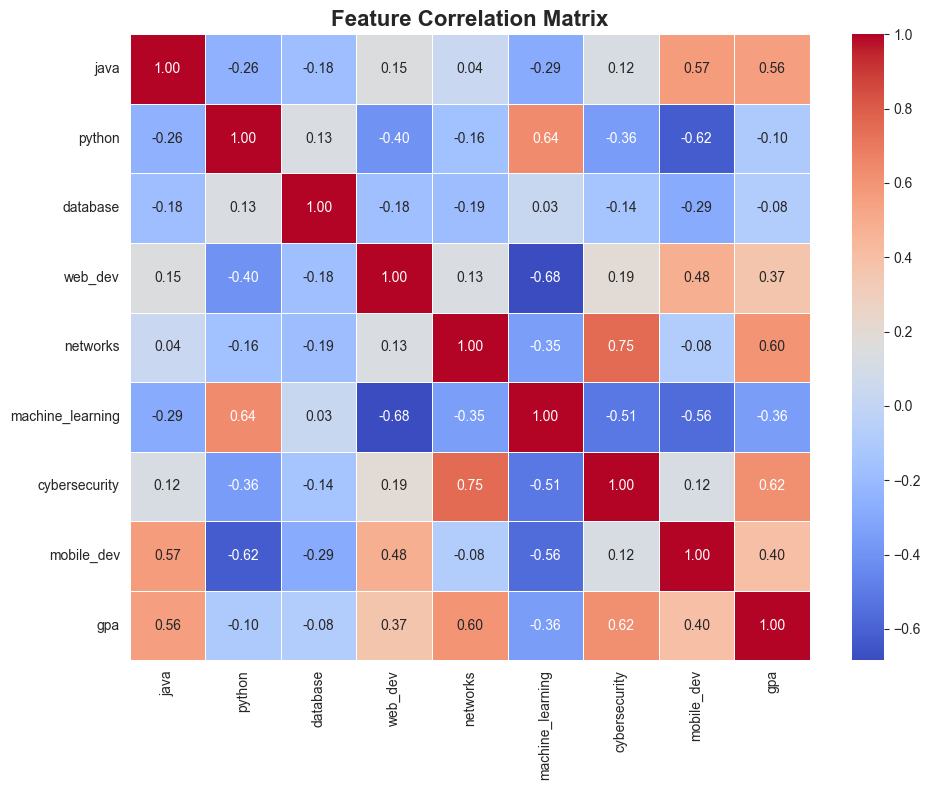

In [81]:
#L 5: Correlation Heatmap
plt.figure(figsize=(10, 8))
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [82]:
#LL 6: Data Cleaning
df_clean = df.copy()
df_clean = df_clean.drop_duplicates()
if df_clean.isnull().sum().sum() > 0:
    print("Handling missing values...")
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
    df_clean[numeric_cols] = df_clean[numeric_cols].fillna(df_clean[numeric_cols].median())
    categorical_cols = df_clean.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if col != 'student_id':
            df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])
print(f"✅ Data cleaned! Shape: {df_clean.shape}")

✅ Data cleaned! Shape: (500, 11)


In [83]:
#L 7: Feature Engineering
df_clean['avg_programming'] = (df_clean['java'] + df_clean['python']) / 2
df_clean['avg_data'] = (df_clean['database'] + df_clean['machine_learning']) / 2
df_clean['avg_security'] = (df_clean['cybersecurity'] + df_clean['networks']) / 2
df_clean['avg_development'] = (df_clean['web_dev'] + df_clean['mobile_dev']) / 2
subject_cols = ['java', 'python', 'database', 'web_dev', 'networks', 'machine_learning', 'cybersecurity', 'mobile_dev']
df_clean['grade_std'] = df_clean[subject_cols].std(axis=1)
df_clean['best_subject'] = df_clean[subject_cols].idxmax(axis=1)
df_clean['worst_subject'] = df_clean[subject_cols].idxmin(axis=1)
print("✅ Feature engineering completed!")
print(f"New features: {list(df_clean.columns[len(df.columns):])}")

✅ Feature engineering completed!
New features: ['avg_programming', 'avg_data', 'avg_security', 'avg_development', 'grade_std', 'best_subject', 'worst_subject']


In [84]:
#L 8: Prepare Features and Target
X = df_clean.drop(['student_id', 'recommended_domain', 'best_subject', 'worst_subject'], axis=1)
y = df_clean['recommended_domain']
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"Features shape: {X.shape}")
print(f"Target shape: {y_encoded.shape}")
print(f"\nFeatures: {list(X.columns)}")
print(f"\nTarget classes: {list(le.classes_)}")

Features shape: (500, 14)
Target shape: (500,)

Features: ['java', 'python', 'database', 'web_dev', 'networks', 'machine_learning', 'cybersecurity', 'mobile_dev', 'gpa', 'avg_programming', 'avg_data', 'avg_security', 'avg_development', 'grade_std']

Target classes: ['AI/ML Engineering', 'Cloud/DevOps', 'Cybersecurity', 'Data Science', 'Database Administration', 'Mobile Development', 'Software Engineering', 'Web Development']


In [85]:
#L 9: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 400
Test set size: 100


In [86]:
#L 10: Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("✅ Data scaled successfully!")

✅ Data scaled successfully!


In [89]:
#L 11: Train All Models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='mlogloss'),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB()
}
results = {}
print("Training models...\n")
print("="*80)
for name, model in models.items():
    print(f"\n🔹 Training {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'f1_score': f1,
        'cv_mean': cv_mean,
        'cv_std': cv_std,
        'predictions': y_pred
    }
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   F1-Score: {f1:.4f}")
    print(f"   CV Score: {cv_mean:.4f} (+/- {cv_std:.4f})")
print("\n" + "="*80)
print("✅ All models trained successfully!")



Training models...


🔹 Training Logistic Regression...
   Accuracy: 0.9000
   F1-Score: 0.8991
   CV Score: 0.9350 (+/- 0.0242)

🔹 Training Random Forest...
   Accuracy: 0.9300
   F1-Score: 0.9282
   CV Score: 0.9300 (+/- 0.0359)

🔹 Training XGBoost...
   Accuracy: 0.9100
   F1-Score: 0.9082
   CV Score: 0.9175 (+/- 0.0341)

🔹 Training LightGBM...
   Accuracy: 0.9300
   F1-Score: 0.9293
   CV Score: 0.9350 (+/- 0.0348)

🔹 Training Gradient Boosting...
   Accuracy: 0.8700
   F1-Score: 0.8651
   CV Score: 0.9025 (+/- 0.0436)

🔹 Training SVM...
   Accuracy: 0.8900
   F1-Score: 0.8854
   CV Score: 0.9200 (+/- 0.0232)

🔹 Training KNN...
   Accuracy: 0.9000
   F1-Score: 0.8954
   CV Score: 0.9000 (+/- 0.0209)

🔹 Training Naive Bayes...
   Accuracy: 0.9100
   F1-Score: 0.9080
   CV Score: 0.9300 (+/- 0.0170)

✅ All models trained successfully!


In [91]:
#LL 12: Model Comparison Table
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'F1-Score': [results[m]['f1_score'] for m in results],
    'CV Mean': [results[m]['cv_mean'] for m in results],
    'CV Std': [results[m]['cv_std'] for m in results]
})
comparison_df = comparison_df.sort_values('Accuracy', ascending=False)
print("\n📊 Model Comparison:")
print(comparison_df.to_string(index=False))


📊 Model Comparison:
              Model  Accuracy  F1-Score  CV Mean   CV Std
      Random Forest      0.93  0.928232   0.9300 0.035882
           LightGBM      0.93  0.929297   0.9350 0.034821
            XGBoost      0.91  0.908152   0.9175 0.034095
        Naive Bayes      0.91  0.908044   0.9300 0.016956
Logistic Regression      0.90  0.899078   0.9350 0.024238
                KNN      0.90  0.895435   0.9000 0.020917
                SVM      0.89  0.885379   0.9200 0.023184
  Gradient Boosting      0.87  0.865140   0.9025 0.043589


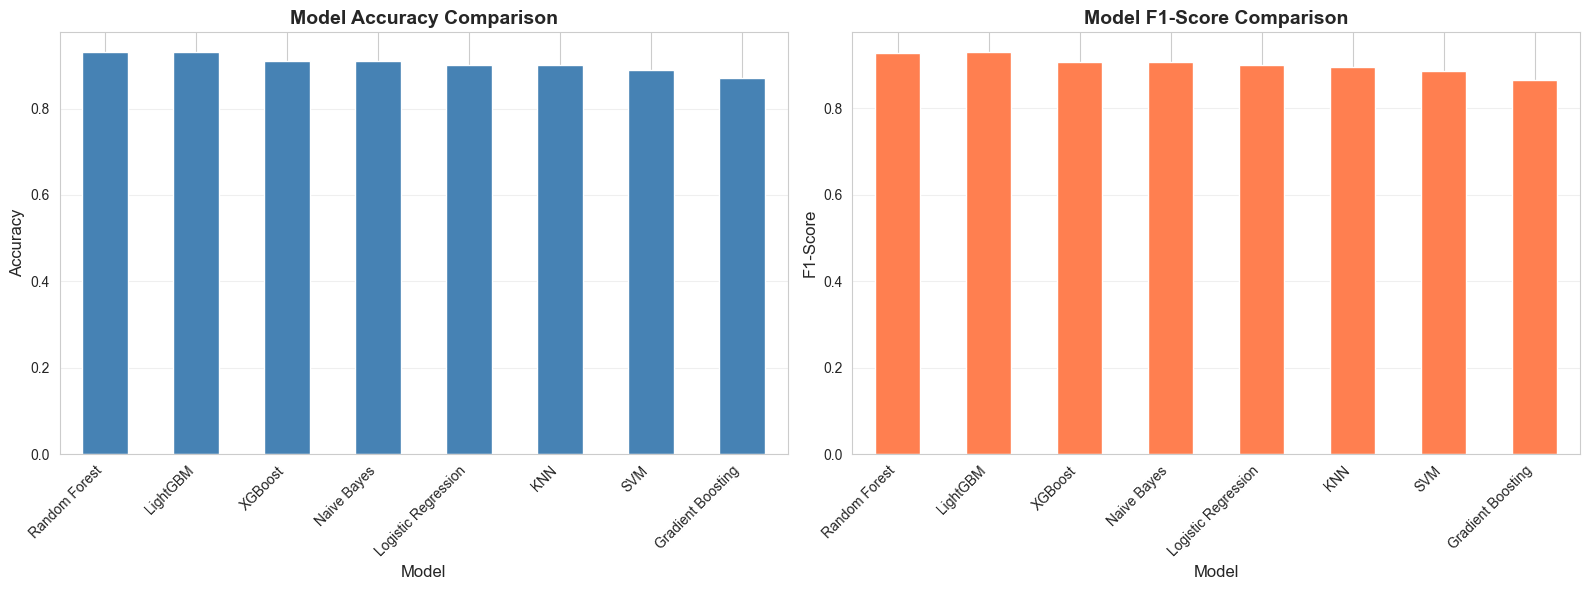

In [92]:
#LL 13: Visualize Model Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
comparison_df.plot(x='Model', y='Accuracy', kind='bar', ax=axes[0], color='steelblue', legend=False)
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0].grid(axis='y', alpha=0.3)
comparison_df.plot(x='Model', y='F1-Score', kind='bar', ax=axes[1], color='coral', legend=False)
axes[1].set_title('Model F1-Score Comparison', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_ylabel('F1-Score', fontsize=12)
axes[1].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [93]:
#L 14: Select Best Model
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
best_predictions = results[best_model_name]['predictions']
print(f"🏆 Best Model: {best_model_name}")
print(f"   Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"   F1-Score: {results[best_model_name]['f1_score']:.4f}")
print(f"   CV Score: {results[best_model_name]['cv_mean']:.4f} (+/- {results[best_model_name]['cv_std']:.4f})")


🏆 Best Model: Random Forest
   Accuracy: 0.9300
   F1-Score: 0.9282
   CV Score: 0.9300 (+/- 0.0359)


In [94]:
#L 15: Classification Report
print("\n📋 Detailed Classification Report:")
print("="*80)
print(classification_report(y_test, best_predictions, target_names=le.classes_))



📋 Detailed Classification Report:
                         precision    recall  f1-score   support

      AI/ML Engineering       0.79      1.00      0.88        15
           Cloud/DevOps       0.90      0.90      0.90        10
          Cybersecurity       1.00      1.00      1.00        11
           Data Science       1.00      0.69      0.82        13
Database Administration       0.90      1.00      0.95         9
     Mobile Development       0.94      1.00      0.97        15
   Software Engineering       1.00      0.83      0.91        12
        Web Development       1.00      1.00      1.00        15

               accuracy                           0.93       100
              macro avg       0.94      0.93      0.93       100
           weighted avg       0.94      0.93      0.93       100



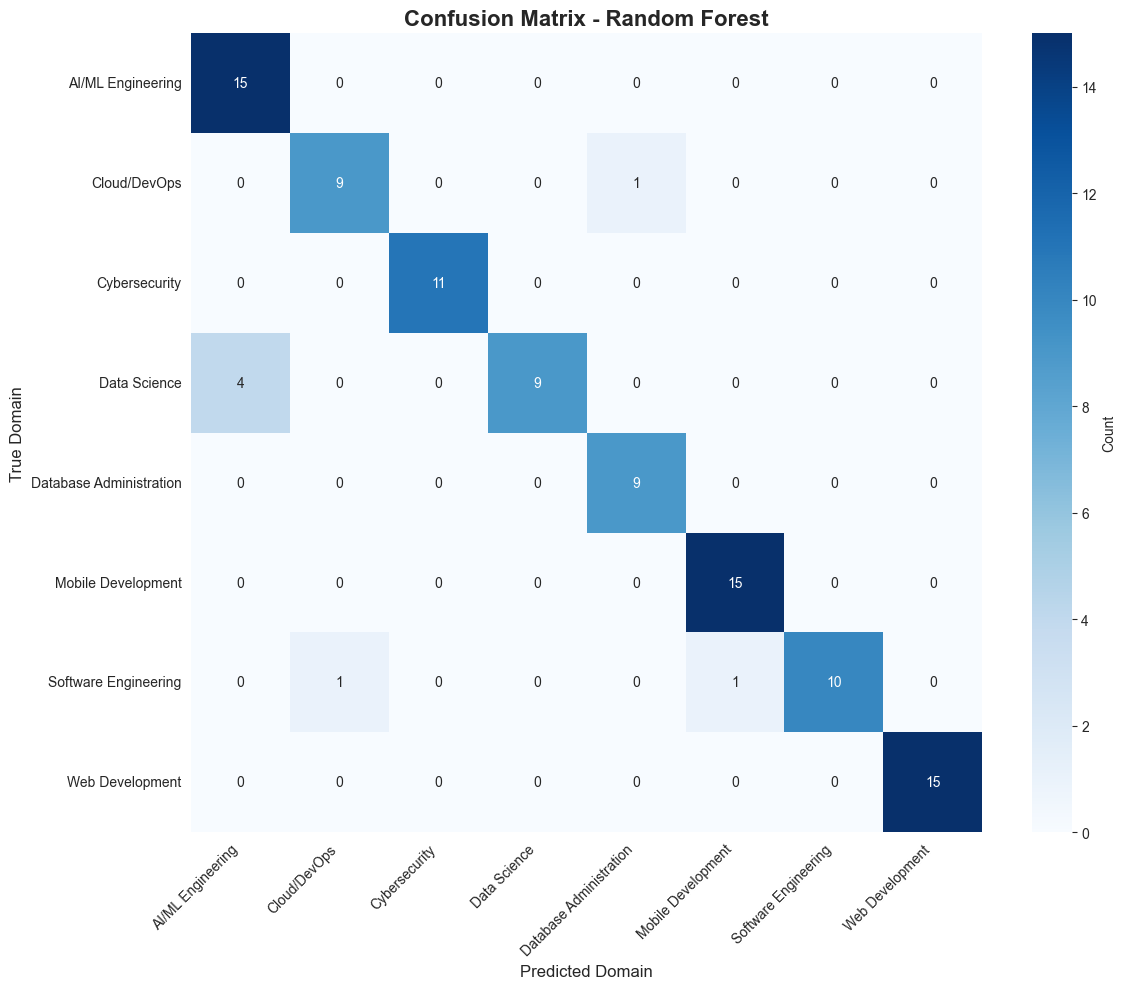

In [95]:
#LL 16: Confusion Matrix
cm = confusion_matrix(y_test, best_predictions)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_, cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Domain', fontsize=12)
plt.ylabel('True Domain', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

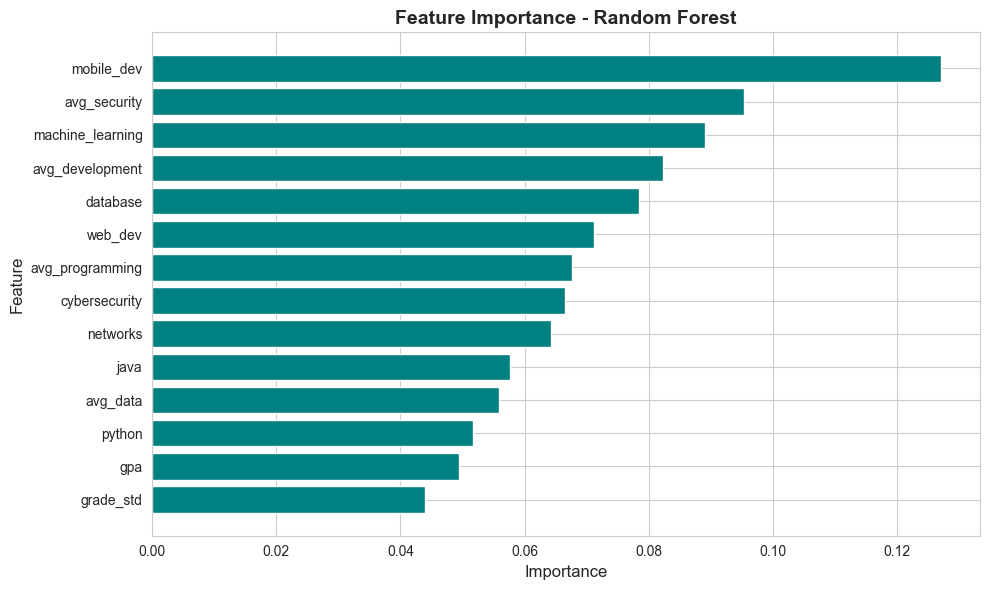


Top 5 Most Important Features:
             feature  importance
7         mobile_dev    0.127033
11      avg_security    0.095294
5   machine_learning    0.089027
12   avg_development    0.082283
2           database    0.078472


In [96]:
#L 17: Feature Importance
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['feature'], feature_importance['importance'], color='teal')
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title(f'Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    print("\nTop 5 Most Important Features:")
    print(feature_importance.head())


In [99]:
#L 19: Save Model
model_artifacts = {
    'model': best_model,
    'scaler': scaler,
    'label_encoder': le,
    'feature_names': list(X.columns),
    'model_name': best_model_name,
    'accuracy': results[best_model_name]['accuracy'],
    'f1_score': results[best_model_name]['f1_score']
}
joblib.dump(model_artifacts, 'academic_recommendation_model.pkl')
print("✅ Model saved as 'academic_recommendation_model.pkl'")
joblib.dump(best_model, f'{best_model_name.lower().replace(" ", "_")}_model.pkl')
print(f"✅ Best model saved as '{best_model_name.lower().replace(' ', '_')}_model.pkl'")
joblib.dump(scaler, 'scaler.pkl')
print("✅ Scaler saved as 'scaler.pkl'")
joblib.dump(le, 'label_encoder.pkl')
print("✅ Label encoder saved as 'label_encoder.pkl'")


✅ Model saved as 'academic_recommendation_model.pkl'
✅ Best model saved as 'random_forest_model.pkl'
✅ Scaler saved as 'scaler.pkl'
✅ Label encoder saved as 'label_encoder.pkl'


In [100]:
#L 20: Load and Test Model
loaded_artifacts = joblib.load('academic_recommendation_model.pkl')
print("✅ Model loaded successfully!")
print(f"Model name: {loaded_artifacts['model_name']}")
print(f"Accuracy: {loaded_artifacts['accuracy']:.4f}")
print(f"F1-Score: {loaded_artifacts['f1_score']:.4f}")


✅ Model loaded successfully!
Model name: Random Forest
Accuracy: 0.9300
F1-Score: 0.9282



🎓 Recommended Domain: AI/ML Engineering


📊 Prediction Probabilities:
                 Domain  Probability
      AI/ML Engineering         0.52
   Software Engineering         0.33
           Cloud/DevOps         0.11
           Data Science         0.02
     Mobile Development         0.02
          Cybersecurity         0.00
Database Administration         0.00
        Web Development         0.00


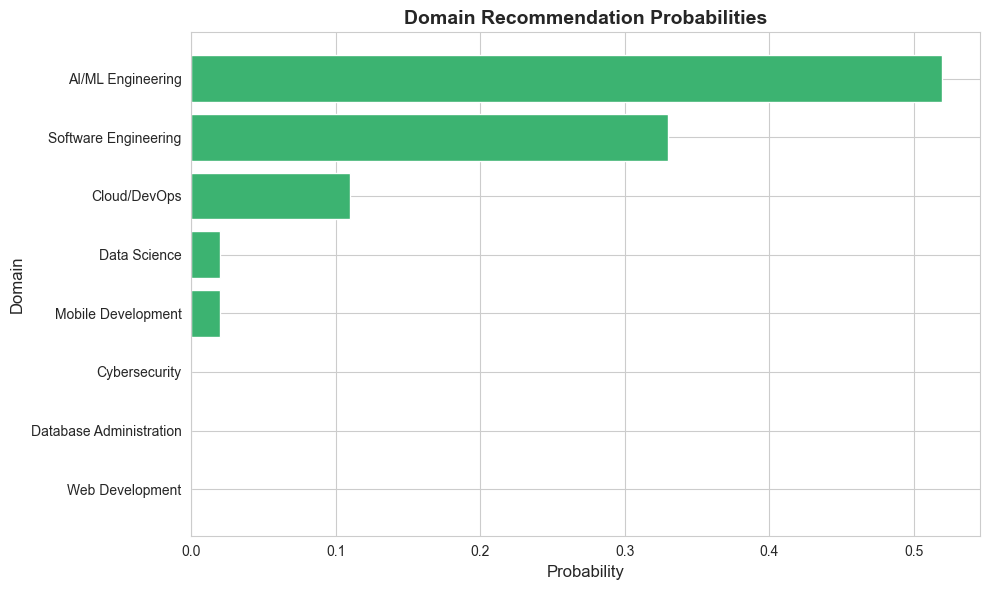

In [101]:
#L 21: Sample Prediction
sample_student = {
    'java': 16.5,
    'python': 18.0,
    'database': 15.0,
    'web_dev': 14.0,
    'networks': 12.0,
    'machine_learning': 19.0,
    'cybersecurity': 13.0,
    'mobile_dev': 14.5,
    'gpa': 15.25
}
sample_student['avg_programming'] = (sample_student['java'] + sample_student['python']) / 2
sample_student['avg_data'] = (sample_student['database'] + sample_student['machine_learning']) / 2
sample_student['avg_security'] = (sample_student['cybersecurity'] + sample_student['networks']) / 2
sample_student['avg_development'] = (sample_student['web_dev'] + sample_student['mobile_dev']) / 2
subject_grades = [sample_student['java'], sample_student['python'], sample_student['database'], sample_student['web_dev'], sample_student['networks'], sample_student['machine_learning'], sample_student['cybersecurity'], sample_student['mobile_dev']]
sample_student['grade_std'] = np.std(subject_grades)
sample_df = pd.DataFrame([sample_student])
sample_df = sample_df[loaded_artifacts['feature_names']]
sample_scaled = loaded_artifacts['scaler'].transform(sample_df)
prediction = loaded_artifacts['model'].predict(sample_scaled)
predicted_domain = loaded_artifacts['label_encoder'].inverse_transform(prediction)[0]
if hasattr(loaded_artifacts['model'], 'predict_proba'):
    probabilities = loaded_artifacts['model'].predict_proba(sample_scaled)[0]
    prob_df = pd.DataFrame({
        'Domain': loaded_artifacts['label_encoder'].classes_,
        'Probability': probabilities
    }).sort_values('Probability', ascending=False)
    print(f"\n🎓 Recommended Domain: {predicted_domain}\n")
    print("\n📊 Prediction Probabilities:")
    print(prob_df.to_string(index=False))
    plt.figure(figsize=(10, 6))
    plt.barh(prob_df['Domain'], prob_df['Probability'], color='mediumseagreen')
    plt.xlabel('Probability', fontsize=12)
    plt.ylabel('Domain', fontsize=12)
    plt.title('Domain Recommendation Probabilities', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print(f"\n🎓 Recommended Domain: {predicted_domain}")